*물류 데이터 분석 요약

- 목표 : 해외에 스포츠 용품을 판매하려는 신규 진입자가 사업 아이템 선정 및 판매 전략 추천
    - 할인의 유효성 확인 및 최적의 할인률 체크 
    - 스포츠 용품 중에서도 어떤 것이 잘 팔리는가? 의류, 골프 축구 등 특정 스포츠 품목, 
    - 스포츠 용품이 정말 효과적으로 판매 되는가?에 대한 제고 

In [51]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('data_cleaned.csv')

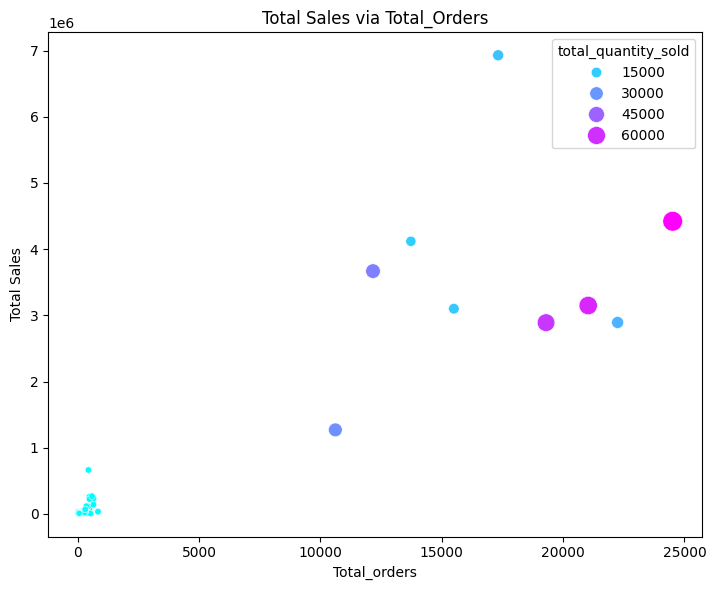

In [52]:
# Grouping data by Product Name to get discount-related metrics
discount_analysis = df.groupby('Product Name').agg(
    total_discount=('Order Item Discount', 'sum'),
    total_sales=('Sales', 'sum'),
    Total_orders=('Product Name', 'count'),
    total_quantity_sold=('Order Item Quantity', 'sum'),
    total_profit=('Order Profit Per Order', 'sum')
).reset_index()
discount_analysis['Mean_discount'] =  discount_analysis['total_discount'] / discount_analysis['total_sales']

# Plotting the relationship between discount and sales, and discount and profit
plt.figure(figsize=(14, 6))

# Subplot 1: Discount vs Sales
plt.subplot(1, 2, 1)
sns.scatterplot(x='Total_orders', y='total_sales', data=discount_analysis, hue='total_quantity_sold', palette='cool', size='total_quantity_sold', sizes=(20, 200))
plt.title('Total Sales via Total_Orders')
plt.xlabel('Total_orders')
plt.ylabel('Total Sales')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

해석 

할인량 및 판매수 그리고 총판매액 비교한 것입니다 

대체로 할인량이 높으면 그만큼 판매액도 높습니다.  

판매액이 높은만큼 판매수량도 높은 경향이 있습니다. 하지만 비싼 단품도 있는만큼 꼭 비례하는 것은 아닙니다. 

할인량 및 판매수 그리고 총수익 비교도 비슷한 경향을 보입니다. 

수익은 -도 있어서 어떻게 분포가 나올지 궁금했는데 역시 모든 상품을 합치니 총수익은 양수가 나왔습니다.

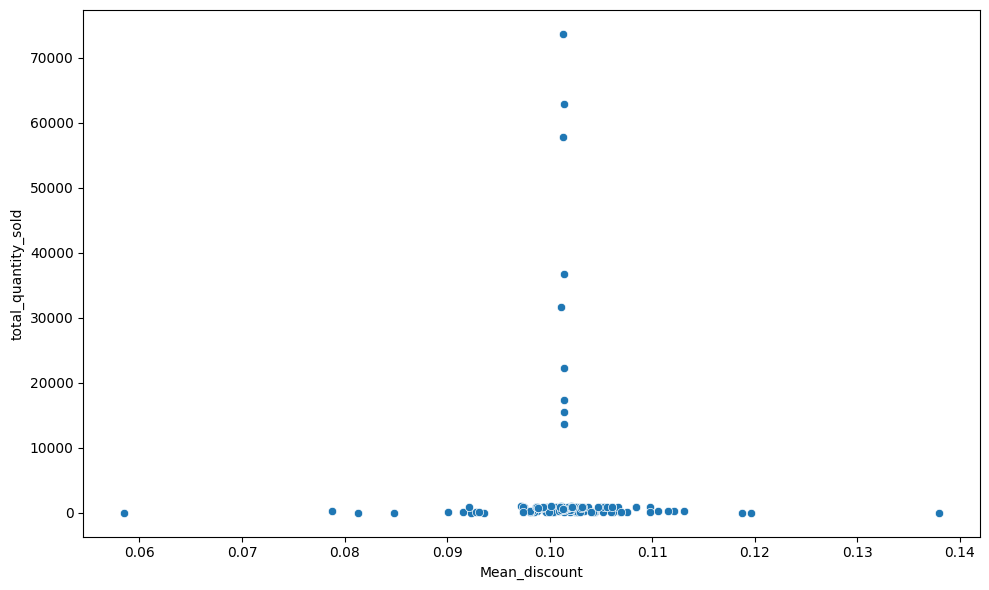

In [53]:
#discount_analysis['Mean_discount'] =  discount_analysis['total_discount'] / discount_analysis['total_sales']

# Plotting the relationship between discount and sales, and discount and profit
plt.figure(figsize=(10, 6))

# Subplot 1: Discount vs Sales
plt.subplot(1, 1, 1)
#sns.scatterplot(x='Mean_discount', y='total_quantity_sold', data=discount_analysis, hue='Total_orders', palette='brg', size='Total_orders', sizes=(20, 200))
sns.scatterplot(x='Mean_discount', y='total_quantity_sold', data=discount_analysis, palette='brg')
plt.title('')
plt.xlabel('Mean_discount')
plt.ylabel('total_quantity_sold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

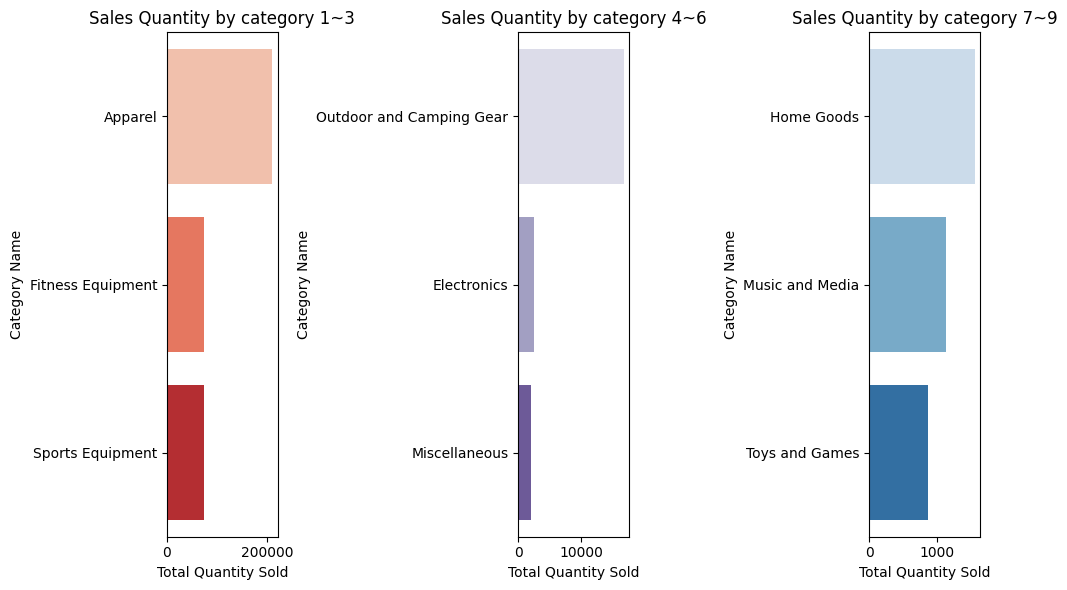

In [60]:
# Group by product name to get total sales and quantity sold per product
category_sales_analysis = df.groupby(['Category Name']).agg(
    total_sales=('Sales', 'sum'),
    total_quantity_sold=('Order Item Quantity', 'sum'),
    total_profit=('Order Profit Per Order', 'sum')
).reset_index()

category_sales_analysis.sort_values(by='total_quantity_sold', ascending=False, inplace=True)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot for top 5 products
plt.subplot(1, 3, 1)
sns.barplot(x='total_quantity_sold', y='Category Name', data=category_sales_analysis[0:3], palette="Reds")
plt.title('Sales Quantity by category 1~3')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Category Name')

# Plot for top 5 products
plt.subplot(1, 3, 2)
sns.barplot(x='total_quantity_sold', y='Category Name', data=category_sales_analysis[3:6], palette="Purples")
plt.title('Sales Quantity by category 4~6')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Category Name')

# Plot for top 5 products
plt.subplot(1, 3, 3)
sns.barplot(x='total_quantity_sold', y='Category Name', data=category_sales_analysis[6:9], palette="Blues")
plt.title('Sales Quantity by category 7~9')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Category Name')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [70]:
category_sales_analysis.head(4)
# 상위 4개 카테고리 이름 추출
top_4_categories = category_sales_analysis.head(4)['Category Name']

# df에서 해당 카테고리 이름과 일치하는 행 필터링
top_4_categories = df[df['Category Name'].isin(top_4_categories)]

In [74]:
top_4_categories['OrderMonth'] = pd.to_datetime(top_4_categories['order date (DateOrders)']).dt.to_period('M')

# 카테고리별로 월 단위로 그룹화하여 평균 할인율 계산
monthly_discount_avg = top_4_categories.groupby(['Category Name', 'OrderMonth']).agg(
    avg_discount=('Order Item Discount Rate', 'mean')
).reset_index()

# 결과 확인
monthly_discount_avg

,Category Name,OrderMonth,avg_discount
0,Apparel,2015-01,0.100711
1,Apparel,2015-02,0.100405
2,Apparel,2015-03,0.101094
3,Apparel,2015-04,0.101697
4,Apparel,2015-05,0.101979
...,...,...,...
137,Sports Equipment,2017-08,0.101944
138,Sports Equipment,2017-09,0.101959
139,Sports Equipment,2017-10,0.097183
140,Sports Equipment,2017-12,0.102574


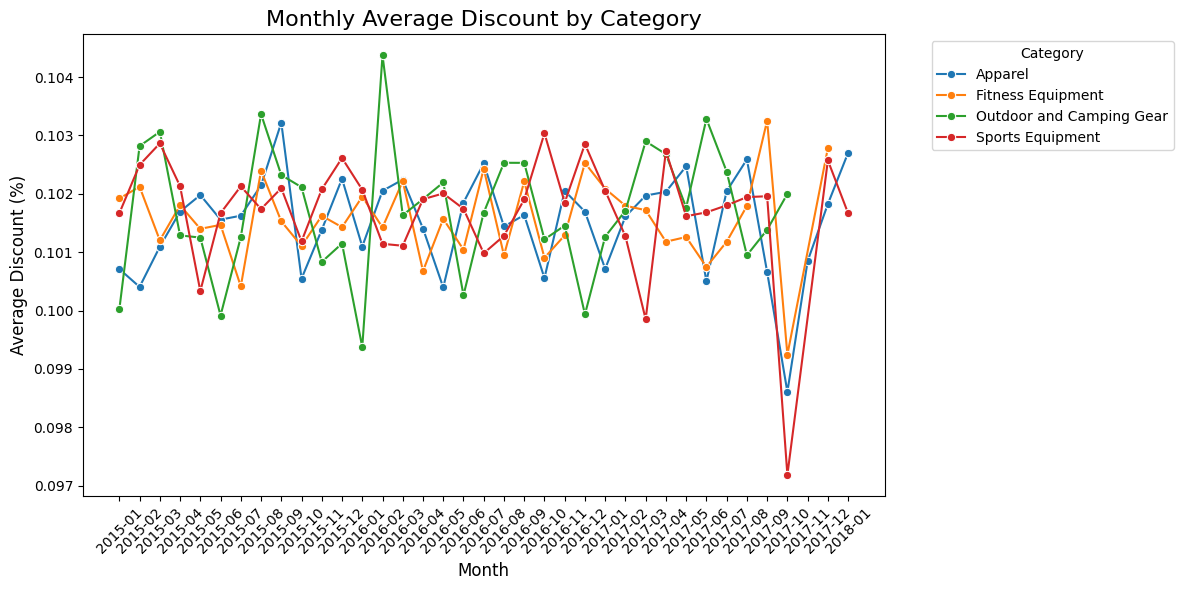

In [75]:
# 시각화를 위해 Month 형식 변환
monthly_discount_avg['OrderMonth'] = monthly_discount_avg['OrderMonth'].astype(str)

# 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_discount_avg, x='OrderMonth', y='avg_discount', hue='Category Name', marker='o')

# 그래프 꾸미기
plt.title('Monthly Average Discount by Category', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Discount (%)', fontsize=12)
plt.xticks(rotation=45)  # x축 레이블을 45도 기울여서 보기 쉽게 함
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # 범례 위치 조정
plt.tight_layout()

# 그래프 출력
plt.show()

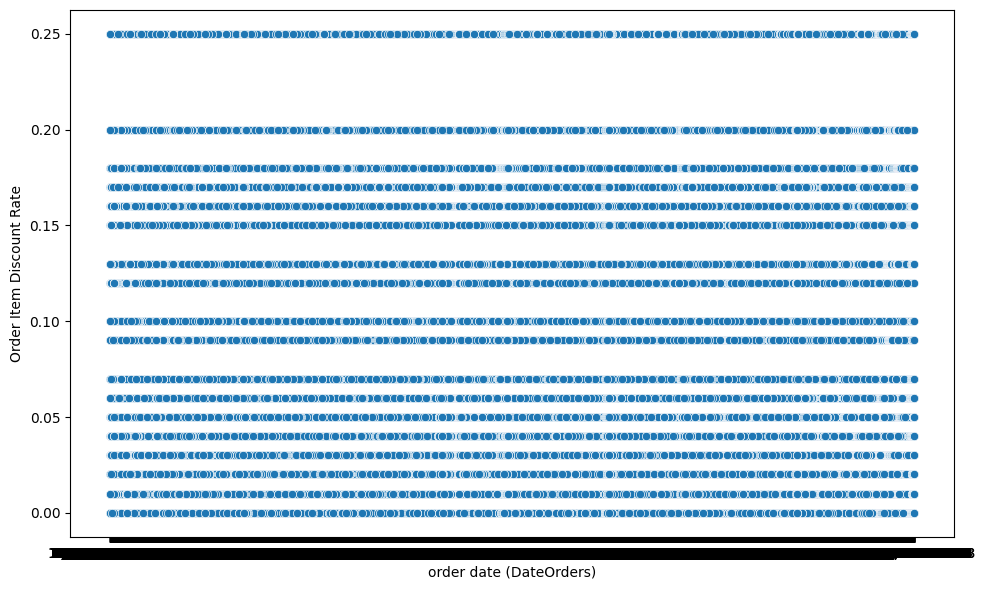

In [73]:
# Plotting the relationship between discount and sales, and discount and profit
plt.figure(figsize=(10, 6))

# Subplot 1: Discount vs Sales
plt.subplot(1, 1, 1)
#sns.scatterplot(x='Mean_discount', y='total_quantity_sold', data=discount_analysis, hue='Total_orders', palette='brg', size='Total_orders', sizes=(20, 200))
sns.scatterplot(x='order date (DateOrders)', y='Order Item Discount Rate', data=top_4_categories, palette='brg')
plt.title('')
plt.xlabel('order date (DateOrders)')
plt.ylabel('Order Item Discount Rate')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [81]:
grouped_category = top_4_categories.groupby('Order Item Discount Rate').agg(
    total_order=('Sales', 'count'),
    total_quantity_sold=('Order Item Quantity', 'sum'),
    total_profit=('Order Profit Per Order', 'sum')
).reset_index()

sns.barplot(x='Order Item Discount Rate', y='total_quantity_sold', data=grouped_category, palette="Reds")
plt.title('Sales Quantity by category 1~3')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Category Name')
plt.show()

,Order Item Discount Rate,total_order,total_quantity_sold,total_profit
0,0.00,9622,20902,246198.022252
1,0.01,9623,20874,222567.551072
2,0.02,9631,20914,217939.430854
3,0.03,9624,20877,207007.800037
4,0.04,9616,20856,218337.820323
5,0.05,9636,20917,224231.229406
6,0.06,9618,20855,222733.240861
7,0.07,9636,20911,219494.520929
8,0.09,9631,20883,214931.190521
9,0.10,9625,20890,213326.509287


상위 판매 품목 
품목의 이익을 알 방법은 없으니 Quantity가 높아야 배송을 맡긴 업체 혹은 개인 입장에선 수익이 날 테니 Quantity를 기준으로 잡았습니다. 

In [57]:
region_category = df[['Order Region', 'Shipping Mode', 'Days for shipping (real)']]

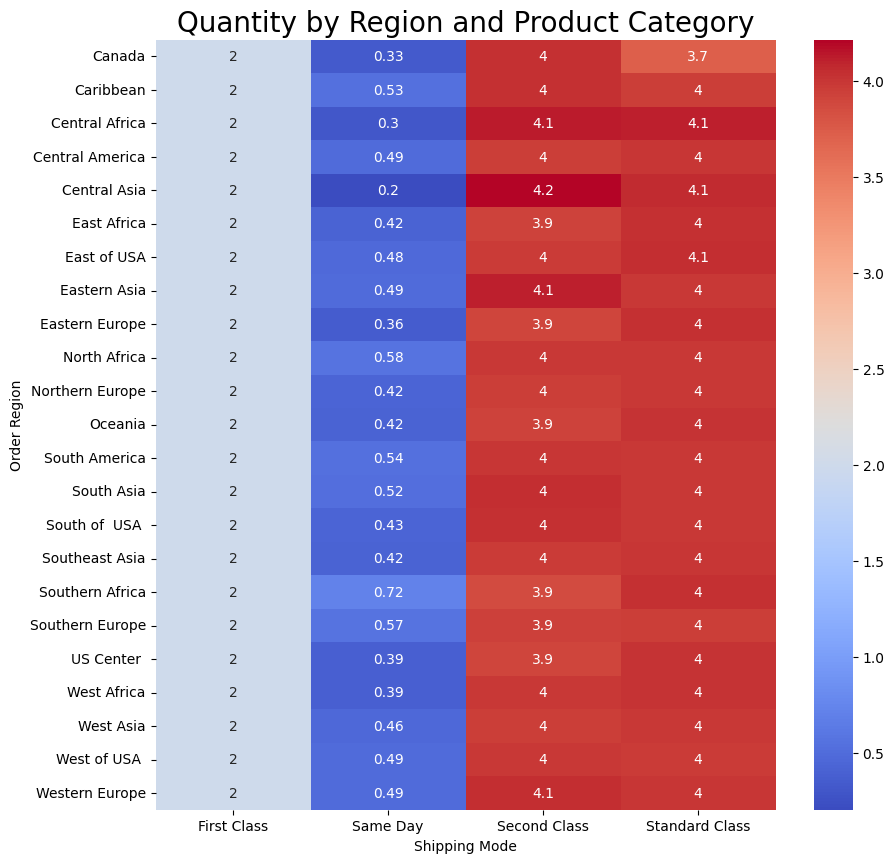

In [58]:
quantity_data = region_category.pivot_table(index='Order Region', columns='Shipping Mode', values='Days for shipping (real)', aggfunc='mean')

plt.figure(figsize=(10, 10))
sns.heatmap(quantity_data, cmap='coolwarm', annot=True)
plt.title('Quantity by Region and Product Category', fontsize=20)
plt.show()

In [ ]:
라이징 마켓을 발굴한다 -> 시간대 기준으로 지역 별로 상향하는 시장 찾기 

추천 판매 지역에 대해서 판매량 변화 보기 

-> 할인에 따른 재구매율 차이가 존재함  -> 이 내용 반영!


배송 모델 별로 배송 성과를 보았을 때 편차가 존재하는가 -> 분포가 실제적으로 얼마나 차이가 나는지를 구체적으로 보았는데 
스탠다드랑 세컨이랑 차이가 없다 -> 만약 배송 서비스를 이용한다면 더 저렴한 스탠다드만을 사용하는 것이 나을 수 있다 

배송 거리에 따라 클래스가 분류되어 있는 게 아닐까? 
거리를 어떻게 구하냐 
위경도를 구하고 거기서부터 계산한다 

출발지는 위경도 데이터가 존재함 

도착지는 주소를 구해서 그걸 기준으로 위경도를 뽑아서 직선 거리를 
